In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
from tqdm import tqdm
import time

## Tools for loading the program versions

In [2]:

def compile_version(version, output=False):
    try:
        result = subprocess.check_output(f"module load daint-gpu && module switch PrgEnv-gnu PrgEnv-cray && module load perftools-lite && cd fortran_programs && make VERSION={version} ", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
        print(f"Version {version} succeeded")

    except subprocess.CalledProcessError as cpe:
        result = cpe.output

    finally:   
        if output:
            for line in result.splitlines():
                print(line.decode())

def compile_all_versions(versions, output=False, clean_old=False):
    if clean_old:
        print("Remove all old outputs")
        subprocess.run(f"cd fortran_programs && make clean", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
    else:
        print("Not removing previously compiled programs")
    for version in versions:
        compile_version(version, output)

In [3]:
versions = ["orig", "gemini_loop_fusion_v2"]

In [4]:
compile_all_versions(versions, output=True, clean_old=True)

Remove all old outputs
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
Version orig succeeded
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-orig.o -o stencil2d-orig.x
INFO: creating the PerfTools-instrumented executable 'stencil2d-orig.x' (lite-samples) ...OK
cp stencil2d-orig.x stencil2d.x
Version gemini_loop_fusion_v2 succeeded
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-gemini_loop_fusion_v2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-gemini_loop_fusion_v2.o -o stencil2d-gemini_loop_fusion_v2.x
INFO: creating the PerfTools-instrumented executable 'stencil2d-gemini_loop_fusion_v2.x' (lite-samples) ...OK
cp stencil2d-gemini_loop_fusion_v2.x stencil2d.x


In [5]:
def execute_version(version, nx=64, ny=64, nz=64, num_iter=1024, attempt=0):
    try:
        result = subprocess.check_output(f"cd fortran_programs && srun -n 12 ./stencil2d-{version}.x+orig --nx {nx} --ny {ny} --nz {nz} --num_iter {num_iter}", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
    except subprocess.CalledProcessError as cpe:
        print("there was an error")
        result = cpe.output
    code_string = result.decode()
    cleaned_up_code_string = ''
    if "Job" in code_string and attempt < 5: 
        for line in code_string.split("\n"):
            if "srun" not in line: 
                cleaned_up_code_string +=line
    else:
        cleaned_up_code_string = code_string
    exec(cleaned_up_code_string, None, globals() )
    return data

def execute_versions(versions, nx=64, ny=64, nz=64, num_iter=1024):
    result = {}
    for version in versions:
        data = execute_version(version, nx=nx, ny=ny, nz=nz, num_iter=num_iter)
        result[version] = data
    return result
    

In [6]:
result = execute_version("gemini_loop_fusion_v2", num_iter=128)
print(result)

[[ 12.         64.         64.         64.        128.          0.2874125]]


In [7]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('fortran_programs/in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('fortran_programs/out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

In [36]:
test_version = "gemini_inlining_v2"
compile_version(test_version, output=True)

Version gemini_inlining_v2 succeeded
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-gemini_inlining_v2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-gemini_inlining_v2.o -o stencil2d-gemini_inlining_v2.x
INFO: creating the PerfTools-instrumented executable 'stencil2d-gemini_inlining_v2.x' (lite-samples) ...OK
cp stencil2d-gemini_inlining_v2.x stencil2d.x


In [37]:
result = execute_version(test_version, num_iter=128)
print(result)

[[1.200000e+01 6.400000e+01 6.400000e+01 6.400000e+01 1.280000e+02
  4.437115e-02]]


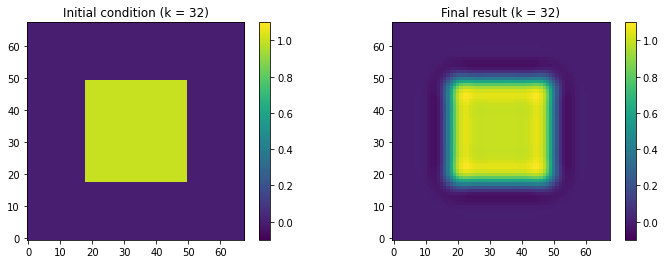

In [38]:
validate_results()

In [16]:
def get_scan_data(version, nxs, nys, nz, num_iter):
    data_sizes = []
    times = []
    print(f"Executing version {version}")
    for nx in tqdm(nxs):
        for ny in nys: 
            runtime = execute_version(version, nx=nx, ny=ny, nz=nz, num_iter=num_iter)[0][-1]
            data_sizes.append(nx * ny * nz * 3 * 4)
            times.append(runtime)
    return np.array(data_sizes), np.array(times)

Executing version orig


100%|██████████| 5/5 [00:54<00:00, 10.93s/it]


Executing version gemini_loop_fusion_v2


100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


Executing version gemini_inlining_v2


100%|██████████| 5/5 [00:41<00:00,  8.27s/it]


Executing version gemini_k_blocking


100%|██████████| 5/5 [00:40<00:00,  8.11s/it]


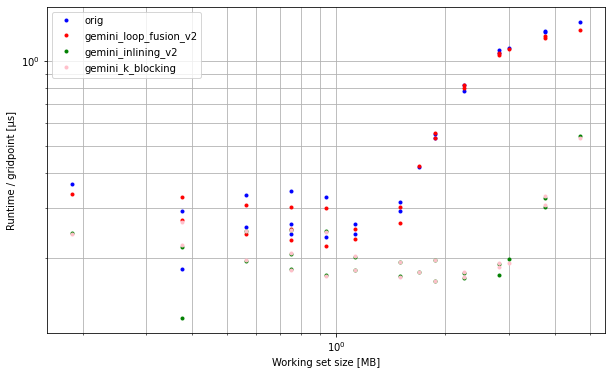

In [17]:
nxs = 16 * np.array([1, 2, 3, 4, 5])
nys = 16 * np.array([1, 2, 3, 4, 5])
nz = 64
num_iter = 128
versions = ["orig",
            # "gemini_loop_fusion",
            "gemini_loop_fusion_v2",
            # "gemini_loop_unroll",
            "gemini_inlining_v2",
            "gemini_k_blocking",
           ]
colors = ["blue", 
          "red", 
          "green",
          "pink",
         ]
for version, color in zip(versions, colors):
    data_sizes, times = get_scan_data(version, nxs, nys, nz, num_iter)
    plt.loglog(data_sizes/ 1024. / 1024., times / data_sizes * 3 * 4 * 1e6, ".", label=version, color=color)
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(visible=True, which='both')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
plt.legend(loc="upper left")